In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import mlflow
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from utils import *

/Users/gerzsonboros/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%pip install optuna

  Using cached scipy-1.8.1-cp38-cp38-macosx_12_0_universal2.macosx_10_9_x86_64.whl (55.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.8.1 which is incompatible.
nilearn 0.10.0 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
evidently 0.2.1 requires scikit-learn>=0.24.0, but you have scikit-learn 0.23.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-optimize

     |████████████████████████████████| 100 kB 964 kB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
df_train, df_test = get_raw_data()

In [12]:
clf1 = setup(data = df_train, 
             target = 'target',
             numeric_features=df_train.columns[0:-1].to_list(),
             silent=True,
             log_experiment = True,
             use_gpu=True,
             experiment_name = 'selected_model',
             fix_imbalance = True, 
             transformation = True, 
             polynomial_features = True,
             feature_selection = True, feature_selection_threshold = 0.5,
             remove_multicollinearity = True, multicollinearity_threshold = 0.6,
            )
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
best = compare_models(sort="APC", 
                      include=["lightgbm", "et", "rf", "lr", "gbc"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9806,0.9876,0.8818,0.9460,0.9109,0.9000,0.9019,0.9563,2.7940
gbc,Gradient Boosting Classifier,0.9755,0.9814,0.9091,0.8820,0.8934,0.8796,0.8809,0.9512,5.9190
rf,Random Forest Classifier,0.9806,0.9835,0.8773,0.9487,0.9100,0.8992,0.9010,0.9499,1.5720
lr,Logistic Regression,0.9658,0.9776,0.9227,0.8090,0.8595,0.8403,0.8443,0.9498,0.1540
et,Extra Trees Classifier,0.9806,0.9825,0.8636,0.9611,0.9087,0.8979,0.9002,0.9459,2.2350


In [7]:
clf1

(353906    0
 23099     0
 69396     0
 329575    0
 335263    0
          ..
 194678    0
 171172    0
 366297    0
 356179    0
 342074    0
 Name: target, Length: 840, dtype: int64,
 'box-cox',
 True,
 Pipeline(memory=None,
          steps=[('fix_imbalance',
                  SMOTE(k_neighbors=5, n_jobs=None, random_state=5228,
                        sampling_strategy='auto'))],
          verbose=False),
 -1,
 '9c29',
 False,
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7fe14e291a90>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7fe14e291af0>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7fe14e291c70>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x7fe14e291d90>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x7fe14e291eb0>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x7fe14a9

In [8]:
best

CustomProbabilityThresholdClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None,
                                     classifier=RandomForestClassifier(bootstrap=True,
                                                                       ccp_alpha=0.0,
                                                                       class_weight=None,
                                                                       criterion='gini',
                                                                       max_depth=None,
                                                                       max_features='auto',
                                                                       max_leaf_nodes=None,
                                                                       max_samples=None,
                                                                       min_impurity_decrease=0.0,
                                                                  

In [9]:
results = predict_model(tuned_dt, raw_score=True, data=df_test)

NameError: name 'tuned_dt' is not defined

# Hyperparameter tuning


# Define search space for hyper parameter tuning

In [6]:
params = {"max_depth": np.random.randint(1, 40, 10),
          "n_estimators": np.random.randint(2, 1000, 10)}
          
# tune model
tuned_dt = tune_model(best, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9823,0.8636,0.9500,0.9048,0.8901,0.8914,0.9437
1,0.9873,0.9966,0.9091,1.0000,0.9524,0.9450,0.9465,0.9839
2,0.9745,0.9751,0.8636,0.9500,0.9048,0.8901,0.8914,0.9514
3,0.9936,0.9904,0.9545,1.0000,0.9767,0.9731,0.9734,0.9742
4,0.9554,0.9851,0.6957,1.0000,0.8205,0.7960,0.8131,0.9490
5,0.9872,0.9969,0.9091,1.0000,0.9524,0.9450,0.9464,0.9843
6,0.9744,0.9735,0.8182,1.0000,0.9000,0.8855,0.8913,0.9341
7,0.9808,0.9983,0.9091,0.9524,0.9302,0.9191,0.9194,0.9909
8,0.9936,0.9993,0.9545,1.0000,0.9767,0.9730,0.9734,0.9962


In [7]:
tuned_dt

CustomProbabilityThresholdClassifier(bootstrap=False, ccp_alpha=0.0,
                                     class_weight=None,
                                     classifier=ExtraTreesClassifier(bootstrap=False,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=31,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_impurity_decrease=0.0,
                                                                     min_impurity_sp

In [8]:
results = predict_model(tuned_dt, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Extra Trees Classifier,0.9773,0.9799,0.8830,0.9679,0.9235,0.9103,0.9116,0.9614


# Voting classifier


In [40]:
tops= compare_models(n_select = 3, sort="APC")
tops

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
et,Extra Trees Classifier,0.9821,0.9888,0.8787,0.9950,0.9315,0.9214,0.9248,0.9663,0.2070
lightgbm,Light Gradient Boosting Machine,0.9815,0.9868,0.9010,0.9684,0.9316,0.9209,0.9229,0.9656,0.1580
rf,Random Forest Classifier,0.9802,0.9860,0.8874,0.9705,0.9262,0.9148,0.9166,0.9639,0.2520
gbc,Gradient Boosting Classifier,0.9764,0.9820,0.9097,0.9243,0.9160,0.9023,0.9029,0.9606,1.3180
lr,Logistic Regression,0.9559,0.9792,0.9231,0.8007,0.8563,0.8305,0.8343,0.9586,0.0210
lda,Linear Discriminant Analysis,0.9719,0.9779,0.8962,0.9060,0.8998,0.8835,0.8843,0.9549,0.0250
ada,Ada Boost Classifier,0.9649,0.9775,0.9053,0.8580,0.8794,0.8589,0.8604,0.9527,0.3180
knn,K Neighbors Classifier,0.9559,0.9668,0.9188,0.8037,0.8559,0.8301,0.8337,0.9155,0.0360
qda,Quadratic Discriminant Analysis,0.9719,0.9541,0.8874,0.9150,0.8990,0.8827,0.8841,0.8976,0.0230
nb,Naive Bayes,0.9687,0.9767,0.8874,0.8960,0.8888,0.8707,0.8726,0.8825,0.0100


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=2423, verbose=0,
                      warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=2423, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_fr

In [41]:
tops[0]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2423, verbose=0,
                     warm_start=False)

In [42]:
blender_weighted = blend_models([tops[0],tops[1],tops[2]], weights = [0.5,0.3,0.2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9809,0.9764,0.8636,1.0000,0.9268,0.9159,0.9192,0.9395
1,0.9809,0.9936,0.9091,0.9524,0.9302,0.9192,0.9195,0.9775
2,0.9745,0.9774,0.9091,0.9091,0.9091,0.8943,0.8943,0.9552
3,0.9936,0.9949,0.9545,1.0000,0.9767,0.9731,0.9734,0.9816
4,0.9618,0.9838,0.7391,1.0000,0.8500,0.8287,0.8411,0.9438
5,0.9808,0.9953,0.9091,0.9524,0.9302,0.9191,0.9194,0.9785
6,0.9744,0.9786,0.8182,1.0000,0.9000,0.8855,0.8913,0.9400
7,0.9872,0.9980,0.9091,1.0000,0.9524,0.9450,0.9464,0.9891
8,0.9808,0.9990,0.9545,0.9130,0.9333,0.9221,0.9224,0.9945


In [43]:
tops= compare_models(n_select = 2)
blender = blend_models(tops)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9809,0.9754,0.8636,1.0000,0.9268,0.9159,0.9192,0.9433
1,0.9809,0.9973,0.9091,0.9524,0.9302,0.9192,0.9195,0.9870
2,0.9745,0.9838,0.9091,0.9091,0.9091,0.8943,0.8943,0.9554
3,0.9936,0.9936,0.9545,1.0000,0.9767,0.9731,0.9734,0.9789
4,0.9618,0.9851,0.7391,1.0000,0.8500,0.8287,0.8411,0.9451
5,0.9808,0.9959,0.9091,0.9524,0.9302,0.9191,0.9194,0.9806
6,0.9744,0.9722,0.8182,1.0000,0.9000,0.8855,0.8913,0.9295
7,0.9872,0.9976,0.9091,1.0000,0.9524,0.9450,0.9464,0.9876
8,0.9808,0.9993,0.9545,0.9130,0.9333,0.9221,0.9224,0.9962


# Hyperparameter tuning with scikit-optimize on voting model

PyCaret integrates seamlessly with many different libraries for hyperparameter tuning. This gives you access to many different types of search algorithms including random, bayesian, optuna, TPE, and a few others. All of this just by changing a parameter. By default, PyCaret using RandomGridSearch from the sklearn and you can change that by using search_library and search_algorithm parameter in the tune_model function.

In [45]:
tuned_dt = tune_model(blender_weighted, search_library = 'scikit-optimize', optimize="APC", n_iter = 50) # https://pycaret.readthedocs.io/en/stable/api/classification.html

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9809,0.9747,0.8636,1.0000,0.9268,0.9159,0.9192,0.9418
1,0.9809,0.9973,0.9091,0.9524,0.9302,0.9192,0.9195,0.9870
2,0.9682,0.9838,0.8636,0.9048,0.8837,0.8653,0.8656,0.9564
3,0.9936,0.9919,0.9545,1.0000,0.9767,0.9731,0.9734,0.9763
4,0.9618,0.9860,0.7391,1.0000,0.8500,0.8287,0.8411,0.9500
5,0.9872,0.9959,0.9091,1.0000,0.9524,0.9450,0.9464,0.9803
6,0.9744,0.9718,0.8182,1.0000,0.9000,0.8855,0.8913,0.9293
7,0.9872,0.9980,0.9091,1.0000,0.9524,0.9450,0.9464,0.9895
8,0.9936,0.9993,0.9545,1.0000,0.9767,0.9730,0.9734,0.9962


In [46]:
results = predict_model(tuned_dt, raw_score=True, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Voting Classifier,0.9764,0.9804,0.8889,0.9560,0.9212,0.9074,0.9082,0.9606


In [55]:
save_model(tuned_dt, 'tuned_dt')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_split=None,
                                                                       min_sampl

In [52]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

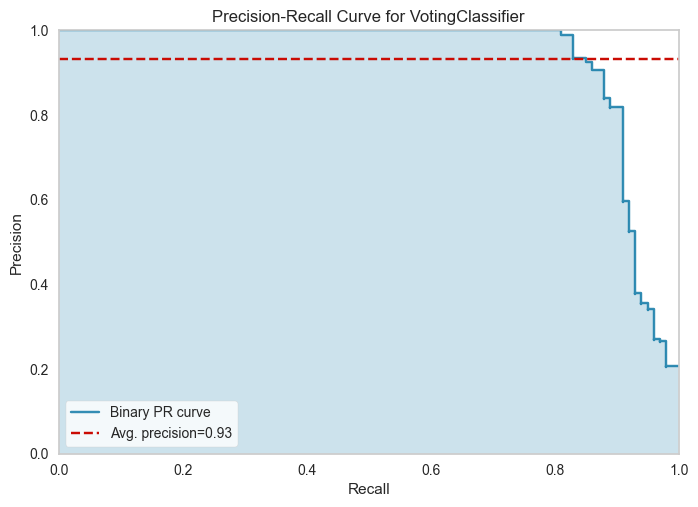

In [48]:
plot_model(tuned_dt, plot = 'pr')

# Create REST API

In [56]:
create_api(tuned_dt, 'fraud_voting_model_api')


API sucessfully created. This function only creates a POST API, it doesn't run it automatically.

To run your API, please run this command --> !python fraud_voting_model_api.py
    


In [59]:
df_test.iloc[-1]

Time      41991.000000
V1           -4.566342
V2            3.353451
V3           -4.572028
V4            3.616119
V5           -2.493138
V6           -1.090000
V7           -5.551433
V8            0.447783
V9           -2.424414
V10          -5.699922
V11           3.586824
V12          -6.636229
V13          -1.128176
V14          -7.245550
V15           0.638326
V16          -6.856810
V17          -8.851879
V18          -4.591883
V19           0.936940
V20          -0.249128
V21           2.674466
V22          -0.020880
V23          -0.302447
V24          -0.086396
V25          -0.516060
V26          -0.295102
V27           0.195985
V28           0.141115
Amount        1.000000
target        1.000000
Name: 44556, dtype: float64

http://127.0.0.1:8001/get_predict?Time=41991.000000&V1=-4.566342&V2=3.353451&V3=-4.572028&V4=3.616119&V5=-2.493138&V6=-1.090000&V7=-5.551433&V8=0.447783&V9=-2.424414&V10=-5.699922&V11=3.586824&V12=-6.636229&V13=-1.128176&V14=-7.245550&V15=0.638326&V16=-6.856810&V17=-8.851879&V18=-4.591883&V19=0.936940&V20=-0.249128&V21=2.674466&V22=-0.020880&V23=-0.302447&V24=-0.086396&V25=-0.516060&V26=-0.295102&V27=0.195985&V28=0.141115&Amount=1

# Create Docker

In [71]:
create_docker('fraud_voting_model_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
        


In [65]:
# Before this you need to install and run Docker desktop
# Please run this in terminal (it needs time) from the jupyter notebook folder
#!docker image build -f "Dockerfile" -t fraud_voting_model_api:latest .

In [70]:
# Please run this in terminal from the appropriate folder
!docker run -d -p 8050:8050 fraud_voting_model_api_with_get

Unable to find image 'fraud_voting_model_api_with_get:latest' locally
docker: Error response from daemon: pull access denied for fraud_voting_model_api_with_get, repository does not exist or may require 'docker login': denied: requested access to the resource is denied.
See 'docker run --help'.
